# Dichtebasiertes Clustering mit OPTICS


![Optics Clustering](optics.png)

Implementieren Sie den Clustering-Algorithmus OPTICS als Jupyter-Notebook! Nutzen Sie das unten gegebene Grundgerüst und beachten Sie die folgenden Anforderungen:

- Kennzeichnen Sie im Code, welcher der Cluster das Rauschen modelliert.
- Der Algorithmus OPTICS liefert eine sortierte Liste der zu clusternden Objekte zusammen mit einigen Daten (aus dieser wird dann mit $\varepsilon'$ das eigentliche Clustering erstellt).
- Benutzen Sie die Euklidische Distanz.
- Nutzen Sie auch andere Datensätze zum Testen. Sie können zum Beispiel auch den iris-Datensatz mit Optics clustern. Überlegen Sie sich verschiedene (sinnvolle) Parameter für $\varepsilon$, $\varepsilon'$ und $\text{minPts}$. Beachten Sie dabei, dass die Ergebnisse nicht immer vollständig Übereinstimmen müssen. Warum?
- Sie müssen kein eigenes Sortierverfahren schreiben. Verwenden Sie stattdessen den Datentyp *SortedListWithKey*. Dafür müssen Sie das Paket *sortedcontainers* installieren, falls
es nicht bereits vorinstalliert ist. Die schon installieten Pakete lassen sich im Terminal (Linux) oder in der Anaconda-Prompt (Windows) durch den Befehl ``conda list`` anzeigen.
Für die Installation gibt es zwei Möglichkeiten.
    - In Anaconda unter Environments *Not installed* auswählen und den Paketnamen im Suchfeld eingeben. Dann den *apply*-Button und *ok* drücken.
    - In der console durch ```pip install sortedcontainers```. Hierbei müssen Sie darauf achten, dass pip sich auf die gleiche Python-Installation oder Virtual Environment bezieht, unter der auch ihr Jupyter-Notebook läuft.
    - Wenn sich im Jupyter-Notebook der Befehl ```import sortedcontainers``` ohne Fehler ausführen lässt, war die Installation erfolgreich.
- Das Ergebnis eines OPTICS-Durchlaufs mit den Parametern $\text{minPts}= 5, \varepsilon = 6.0, \varepsilon' = 6.0$ finden Sie auf dem Bild *optics.png*.
- Der Algorithmus OPTICS und die Berechnung eines Clusterings aus dessen Ergebnis werden ausführlich und mit Pseudocode im Artikel von Ankerst et al. vorgestellt. (Download unter: http://dx.doi.org/10.1145/304182.304187)
- Ihre Implementierung können Sie bis zum 01.12.2023, 23:59 Uhr in Moodle abgeben.
- Sie dürfen und sollen die externen Pakete Numpy und sortedcontainers verwenden. Außerdem benötigen Sie für die Testfunktionen matplotlib und pandas. Für die 6 ECTS Aufgabe benötigen Sie, wie Sie unten sehen, weiterhin die Pakete math und scipy. Benutzen Sie keine weiteren Drittbibliotheken!
Sollten Sie Fragen zu den Aufgaben haben, wenden Sie sich bitte per E-Mail an [Tobias Hille](mailto:hille@cs.uni-kassel.de).

---
## Zusatzaufgabe für 6 ECTS:
#### Bearbeiten Sie diese Aufgabe nur, falls Sie am Praktikum für 6 ECTS-Punkte teilnehmen, jedoch nicht, falls Sie am Praktikum für 3 ECTS-Punkte teilnehmen.
Optics liefert eine Clusterordnung bezüglich der Parameter $\varepsilon$ und MinPts.
Die Qualität der Ergebnisse hängt also maßgeblich von diesen Parametern ab. In der Vorlesung und in dem Paper von Ankerst et al werden Möglichkeiten vorgestellt, wie diese anhand eines gegebenen Datensatzes sinnvoll gewählt werden können. Implementieren Sie die Klassenmethode ``from_heuristics``, welche ein Element der Klasse Optics erstellt und dabei die Parameter $\varepsilon$ und MinPts anhand des gegebenen Datensatzes selber wählen kann. Die Funktion soll zu einem gegebenem Datensatz ``examples`` die Parameter wie folgt bestimmen:
- Der Parameter MinPts KANN vorgeben werden. Ist er nicht vorgegeben (d.h. er hat den Defaultwert None), so soll er mit der Formel $Minpts = 2*d+2$ berechnet werden. Hierbei ist $d$ die Dimensionalität des Datensatzes.
- Der Parameter $\varepsilon$ soll mittels der Formel für $r$ in Kapitel 4 des Paper bestimmt werden. Hierbei benötigen sie $Volume_{DS}$, das Volumen des Datensatzes. Dies können sie wie folgt (sehr grob) approximieren. Hat ihr Datensatz $n$ Dimensionen, so berechnen sie für jedes $i \in \{1,..,n\}$ den Wert $x_i$ als Differenz von dem größten bezüglich dieser Koordinate vorkommenden Wertes minus dem kleinsten vorkommenden Wertes. Das Volumen kann dann mitels des Produktes $Volume_{DS} = \prod_{i=1}^n x_i$ berechnet werden. Beispiel: Der Datensatz $\{(1, 5, 3), (3, -1, -2), (7, 0, 0)\}$ hätte das Volumen $(7-1) * (5-(-1)) *(3-(-2))=6*6*5=180$.

**Hinweis:** Um zu verstehen wie Klassenmethoden in Python funktionieren, können Sie sich zum Beispiel (https://stackabuse.com/pythons-classmethod-and-staticmethod-explained/) anschauen.

Ein wichtiges Feature des Optics Algorithmus ist, dass er visuell interpretierebare Daten über die Clusterstruktur liefert.

- Veranschaulichen Sie die Reachability-Werte durch einen Plot analog zu den Plots im Paper. Schreiben Sie eine Funktion `run_and_plot2`, die, analog zu `run and plot`, Optics ausführt und dann das Reachabilitydiagramm printet. Dabei soll ihre Implementierungen auch in der Lage sein, die Paramater $\varepsilon$ und MinPts mittels ``from_heuristics`` zu bestimmen, falls sie nicht übergeben werden.

# Implementierung

In [7]:
# Just needed for 6ECTS. Delete for 3 ECTS!
from math import pi

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.special import gamma
from sortedcontainers import SortedListWithKey


def euclidean_dist(x, y):
    return np.linalg.norm(np.array(x) - np.array(y))


class Optics:

    def __init__(self, epsilon=6.0, min_pts=5, dist_fun=euclidean_dist):
        self.epsilon = epsilon
        self.min_pts = min_pts
        self.dist_fun = dist_fun

    # Algorithmus aus Übungsball 5
    def extract_clustering(self, cluster_order, epsilon_prime):
        assert epsilon_prime <= self.epsilon

        # Behandle None Werte
        for c in cluster_order:
            if c.reachability_distance is None:
                c.reachability_distance = epsilon_prime + 1
            if c.core_distance is None:
                c.core_distance = epsilon_prime + 1

        cluster_ids = []
        cluster_id = 0  # 0 is Noise

        for c in cluster_order:
            if c.reachability_distance > epsilon_prime:
                if c.core_distance <= epsilon_prime:
                    cluster_id += 1
                    cluster_ids.append(cluster_id)
                else:
                    cluster_ids.append(0)
            else:
                cluster_ids.append(cluster_id)
        return cluster_ids

    # Algorithmus aus obiger Quelle
    def optics(self, objects):
        cluster_order = []
        data = [OpticsData(o) for o in objects]
        for d in data:
            if not d.processed:
                self.expand_cluster_order(data, d, cluster_order)

        return cluster_order

    def expand_cluster_order(self, data, d, cluster_order):
        neighbors = d.neighbors(data, self.epsilon, self.dist_fun)
        d.set_core_distance(neighbors, self.min_pts, self.dist_fun)
        d.processed = True
        cluster_order.append(d)
        
        if d.core_distance is not None:
            # Sammle direkt-dichte erreichbare Objekte
            orderSeeds = OrderSeeds()
            orderSeeds.update(neighbors, d)
            while not orderSeeds.is_empty():
                # Wähle das am nächsten direkt-dichte erreichbare Objekte und füge es zu Ausgabe
                s = orderSeeds.seeds.pop(0)
                neighbors = s.neighbors(data, self.epsilon, self.dist_fun)
                s.set_core_distance(neighbors, self.min_pts, self.dist_fun)
                s.processed = True
                cluster_order.append(s)
                if s.core_distance is not None:
                    # Sammle direkt-dichte erreichbare Objekte
                    orderSeeds.update(neighbors, s)

    @classmethod
    def from_heuristics(cls, examples, min_pts=None, dist_fun=euclidean_dist):
        d = len(examples[0])
        min_pts = min_pts if min_pts is not None else 2 * d + 2
        m = np.matrix(examples)
        volume = np.prod(m.max(axis=0) - m.min(axis=0))
        epsilon = np.power(((volume * min_pts * gamma((d / 2) + 1)) / (len(examples) * np.sqrt(pi ** d))),
                           1 / d)
        return cls(epsilon, min_pts, dist_fun)


class OpticsData:
    """
    This class should be used to store the needed information of
    each individual example (i.e. datapoint).
    """

    def __init__(self, example):
        self.example = example
        self.core_distance = None
        self.reachability_distance = None
        self.processed = False

    def __str__(self):
        return "".join(str(i) + " " for i in self.example) + str(self.core_distance) + " " + str(
            self.reachability_distance) + " " + str(self.processed)

    def __repr__(self):
        return self.__str__()

    def set_core_distance(self, neighbors, min_pts, dist_fun):
        if len(neighbors) >= min_pts:
            dist = [dist_fun(n.example, self.example) for n in neighbors]
            dist.sort()
            self.core_distance = dist[min_pts - 2]

    def neighbors(self, data, epsilon, dist_fun):
        return [d for d in data if dist_fun(d.example, self.example) <= epsilon]


class OrderSeeds:

    def __init__(self, dist_fun=euclidean_dist):
        self.dist_fun = dist_fun
        self.seeds = SortedListWithKey([], key=lambda obj: obj.reachability_distance)

    def is_empty(self):
        return len(self.seeds) == 0

    def update(self, neighbors, center_object):
        core_dist = center_object.core_distance
        for n in neighbors:
            if not n.processed:
                new_reachability_distance = max(core_dist, self.dist_fun(n.example, center_object.example))
                if n.reachability_distance is None:
                    n.reachability_distance = new_reachability_distance
                    self.seeds.add(n)
                else:
                    if new_reachability_distance < n.reachability_distance:
                        self.seeds.remove(n)
                        n.reachability_distance = new_reachability_distance
                        self.seeds.add(n)


def run_and_plot2(examples, epsilon=None, min_pts=None):
    if not min_pts or not epsilon:
        optics = Optics.from_heuristics(examples, min_pts)
    else:
        optics = Optics(epsilon=epsilon, min_pts=min_pts)
    cluster_order = optics.optics(examples)

    x = list(range(0, len(cluster_order)))

    for c in cluster_order:
        if c.reachability_distance is None:
            c.reachability_distance = optics.epsilon

    y = [c.reachability_distance for c in cluster_order]

    plt.bar(x, y)
    plt.show()


# Ausführen des Clusterings
Hier kann der implementierte Algorithmus getestet werden. Bitte an den vorhandenen Zellen nichts ändern. Sie können aber weitere Zellen mit eigenem Code hinzufügen oder andere Parameterwerte ausprobieren (die Sie in der Abgabe dann wieder auf die ursprünglichen Werte ändern).

In [8]:
def run_and_plot(examples, epsilon=None, min_pts=None, epsilon_prime=1):
    # Run OPTICS and DBSCAN
    if not epsilon:
        optics = Optics.from_heuristics(examples, min_pts)
    else:
        optics = Optics(epsilon=epsilon, min_pts=min_pts)
    cluster_order = optics.optics(examples)
    cluster_ids = optics.extract_clustering(cluster_order, epsilon_prime)

    # Plot the clusters
    unique_clusters = set(cluster_ids)
    plt.figure()
    for cluster_id in unique_clusters:
        examples_for_cluster = [
            cluster_order[i].example for i in range(len(cluster_ids))
            if cluster_ids[i] == cluster_id
        ]
        x, y = [ex[0] for ex in examples_for_cluster
                ], [ex[1] for ex in examples_for_cluster]
        plt.scatter(x, y)
    plt.show()

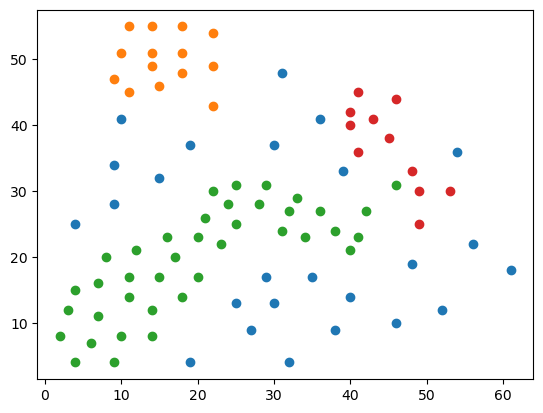

In [9]:
data = pd.read_csv("punkte.csv", header=None)
examples = data.values.tolist()
run_and_plot(examples, epsilon=6.0, min_pts=5, epsilon_prime=6.0)

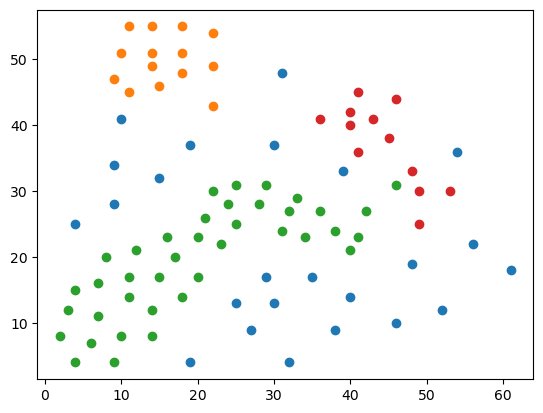

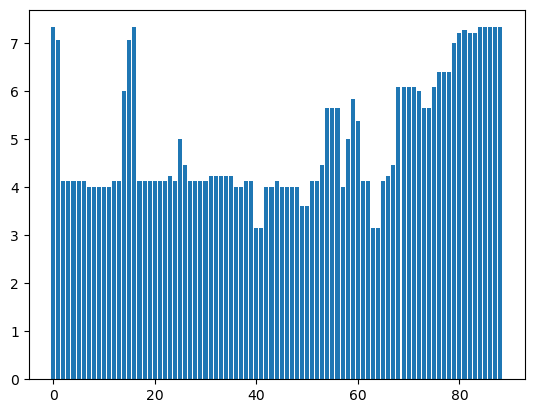

In [10]:
# Delete this cell if you just need 3 ECTS!
run_and_plot(examples, epsilon_prime=6.0)
run_and_plot2(examples, min_pts=5)

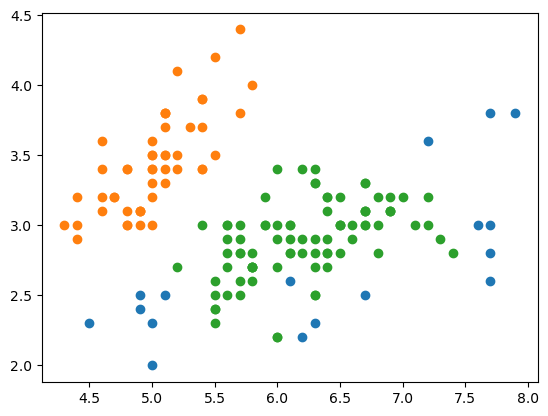

In [11]:
data = pd.read_csv("iris.csv")
del data["species"]
examples = data.values.tolist()
run_and_plot(examples, epsilon=0.5, epsilon_prime=0.5, min_pts=5)

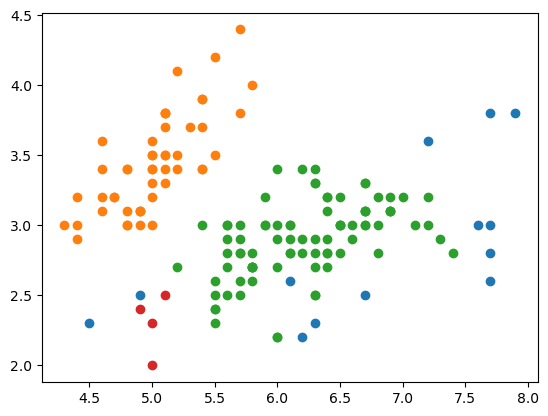

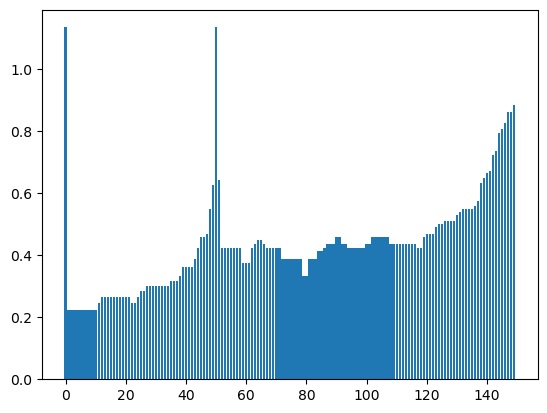

In [12]:
# Delete this cell if you just need 3 ECTS!
run_and_plot(examples, min_pts=5, epsilon_prime=0.5)
run_and_plot2(examples)